# Project overview

This project develops a machine learning model to predict whether a client will subscribe to a term deposit at a bank. The dataset comes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/222/bank+marketing) , based on direct marketing campaigns conducted by a Portuguese banking institution.

We will be working with the file `bank-additional-full.csv`, which can be downloaded [here](https://drive.google.com/file/d/1pDr0hAOnu1JsEiJeBu_F2Jv0GPxKiujW/view).

## Feature Description

| Feature    | Description                                            | Data Type  |
|------------|--------------------------------------------------------|------------|
| `age`      | Client's age                                            | Numerical  |
| `job`      | Type of job                                             | Categorical|
| `marital`  | Marital status                                          | Categorical|
| `education`| Education level                                         | Categorical|
| `default`  | Has credit in default?                                  | Binary     |
| `balance`  | Average yearly balance in euros                         | Numerical  |
| `housing`  | Has housing loan?                                       | Binary     |
| `loan`     | Has personal loan?                                      | Binary     |
| `contact`  | Contact communication type (last contact)               | Categorical|
| `day`      | Last contact day of the month                           | Numerical  |
| `month`    | Last contact month of the year                          | Categorical|
| `duration` | Duration of last contact in seconds                     | Numerical  |
| `campaign` | Number of contacts performed during this campaign       | Numerical  |
| `pdays`    | Number of days since last contact in a previous campaign| Numerical  |
| `previous` | Number of contacts before this campaign                 | Numerical  |
| `poutcome` | Outcome of the previous marketing campaign              | Categorical|
| `y`        | Did the client subscribe to a term deposit? (target)    | Binary     |


## Problem Statement
We aim to develop a classification model to determine if a client will subscribe to a term deposit based on their personal, financial, and historical interactions with the bank.

## Key Project Goals
- Build a robust classification model for subscription prediction.
- Identify key factors influencing client decisions.
- Offer actionable insights to improve marketing campaign effectiveness.

## Main Objective
To build a binary classification model that predicts term deposit subscription outcomes.

## Practical Application
This analysis is common in industries reliant on forecasting customer actions, such as banking, finance, and e-commerce.

# Imports and Initial Setup

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, classification_report, f1_score

from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

import xgboost as xgb
from xgboost import XGBClassifier

from hyperopt import fmin, tpe, hp, Trials

# Setting display options for easier visualization of data
pd.set_option('display.max.rows', 130)
pd.set_option('display.max.columns', 130)
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.expand_frame_repr', False)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# Loading Dataset

In [ ]:
df = pd.read_csv("bank-additional-full.csv", sep = ';')

In [30]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no


# Exploratory Data Analysis (EDA)

In this section, we will explore the dataset and investigate the relationships between key features that could affect a client's decision to subscribe to a term deposit.

In [31]:
df.shape

(41188, 21)

The dataset has 41,188 rows and 21 columns.

In [ ]:
# Checking the structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
# Summary statistics for numeric features
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00
mean,40.02,258.29,2.57,962.48,0.17,0.08,93.58,-40.50,3.62,5167.04
std,10.42,259.28,2.77,186.91,0.49,1.57,0.58,4.63,1.73,72.25
min,17.00,0.00,1.00,0.00,0.00,-3.40,92.20,-50.80,0.63,4963.60
25%,32.00,102.00,1.00,999.00,0.00,-1.80,93.08,-42.70,1.34,5099.10
50%,38.00,180.00,2.00,999.00,0.00,1.10,93.75,-41.80,4.86,5191.00
75%,47.00,319.00,3.00,999.00,0.00,1.40,93.99,-36.40,4.96,5228.10
max,98.00,4918.00,56.00,999.00,7.00,1.40,94.77,-26.90,5.04,5228.10


The dataset contains 41,188 rows and 21 columns. All columns are fully populated, and no missing values were detected.

In [ ]:
# Check missing values
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

The dataset contains no missing values, which is advantageous as no imputation will be required.

**Target Variable (y) Distribution**

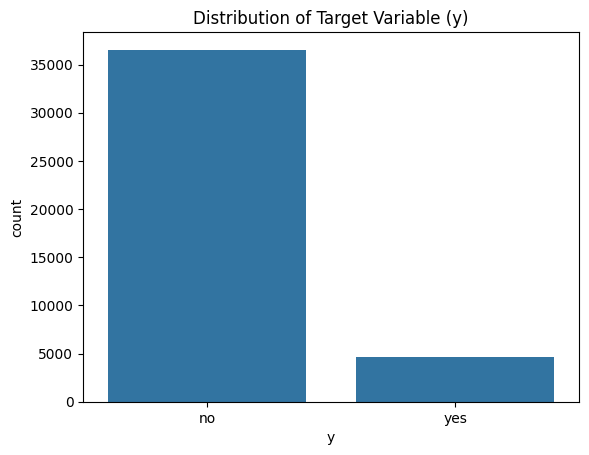

y
no    0.89
yes   0.11
Name: proportion, dtype: float64


In [35]:
# Distribution of the target variable
sns.countplot(data = df, x = 'y')
plt.title('Distribution of Target Variable (y)')
plt.show()

# Checking the frequency of target classes
print(df['y'].value_counts(normalize=True))

The target variable is imbalanced. Most clients did not subscribe to the term deposit, with a significant portion of the dataset labeled as "no" compared to "yes". This imbalance will need to be considered when building models.

**Analyzing Categorical Variables**

In [36]:
# Extracting categorical features
categorical_features = df.select_dtypes(include = 'object').columns

# Number of categorical variables
print(len(categorical_features))

categorical_features

11


Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

The dataset contains 11 categorical variables.

**Distribution of Categorical Variables**

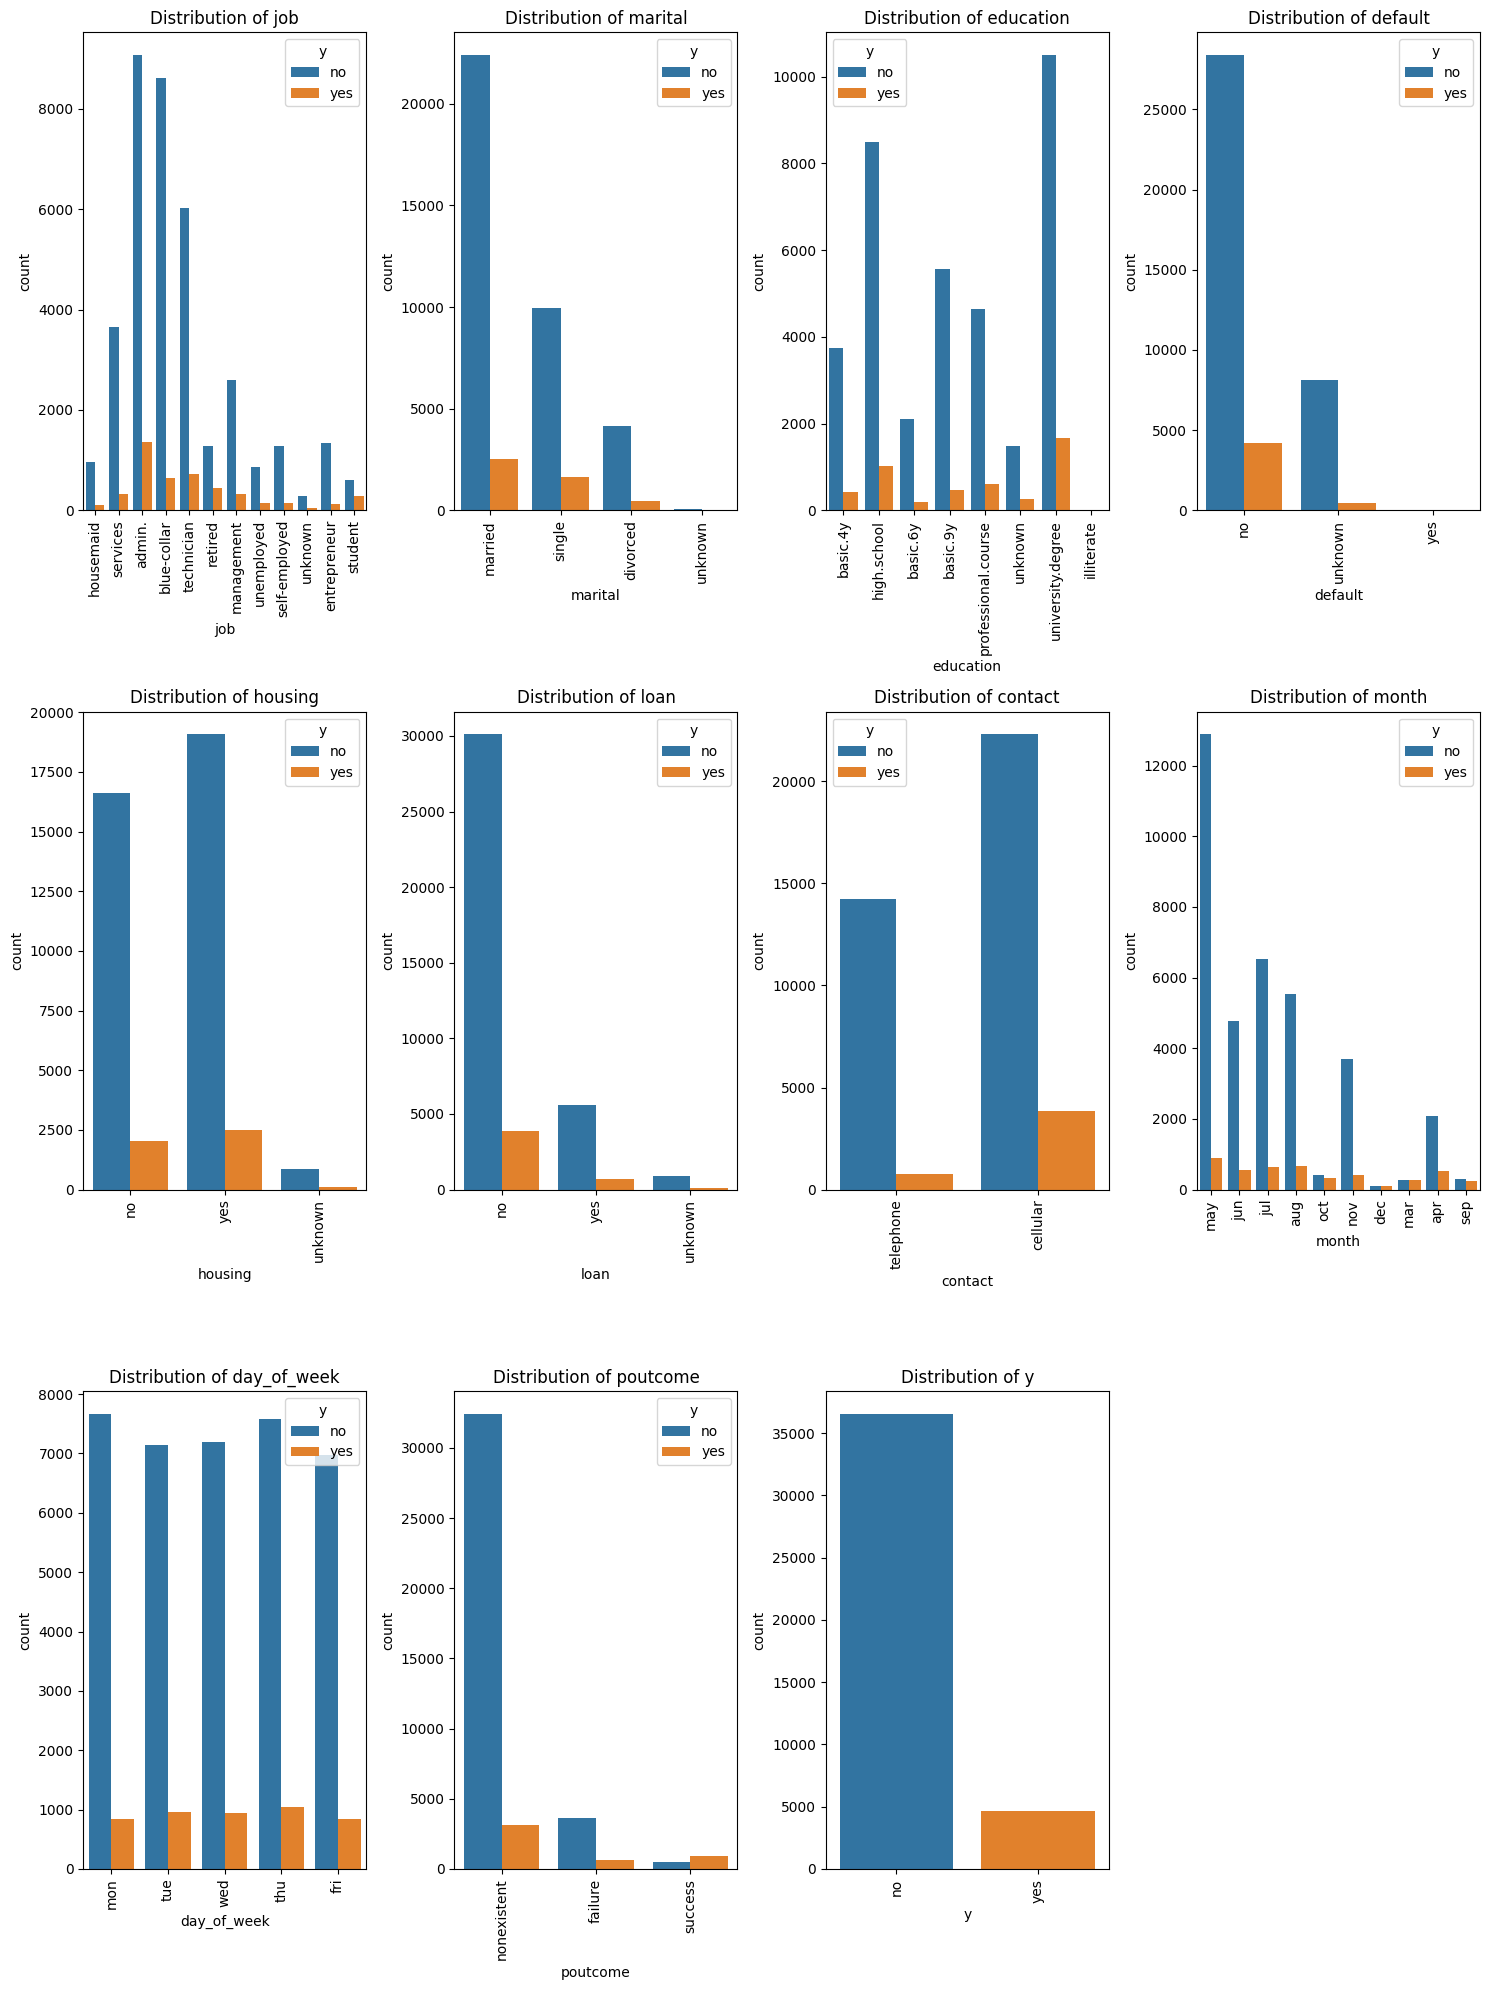

In [37]:
# Visualizing the distribution of categorical features

plt.figure(figsize = (15, 20))
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 4, i + 1)
    sns.countplot(data = df, x = feature, hue = 'y')
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

**Analyzing Numerical Variables**

In [38]:
# Extracting numerical features
number_df = df.select_dtypes(include = 'number')
number_df.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [39]:
# Number of numerical variables
len(number_df.columns)     

10

The dataset contains 10 numerical variables.

**Distribution of Numerical Variables**

The histograms reveal the distribution of each numerical feature. We will analyze how these distributions might impact the model.

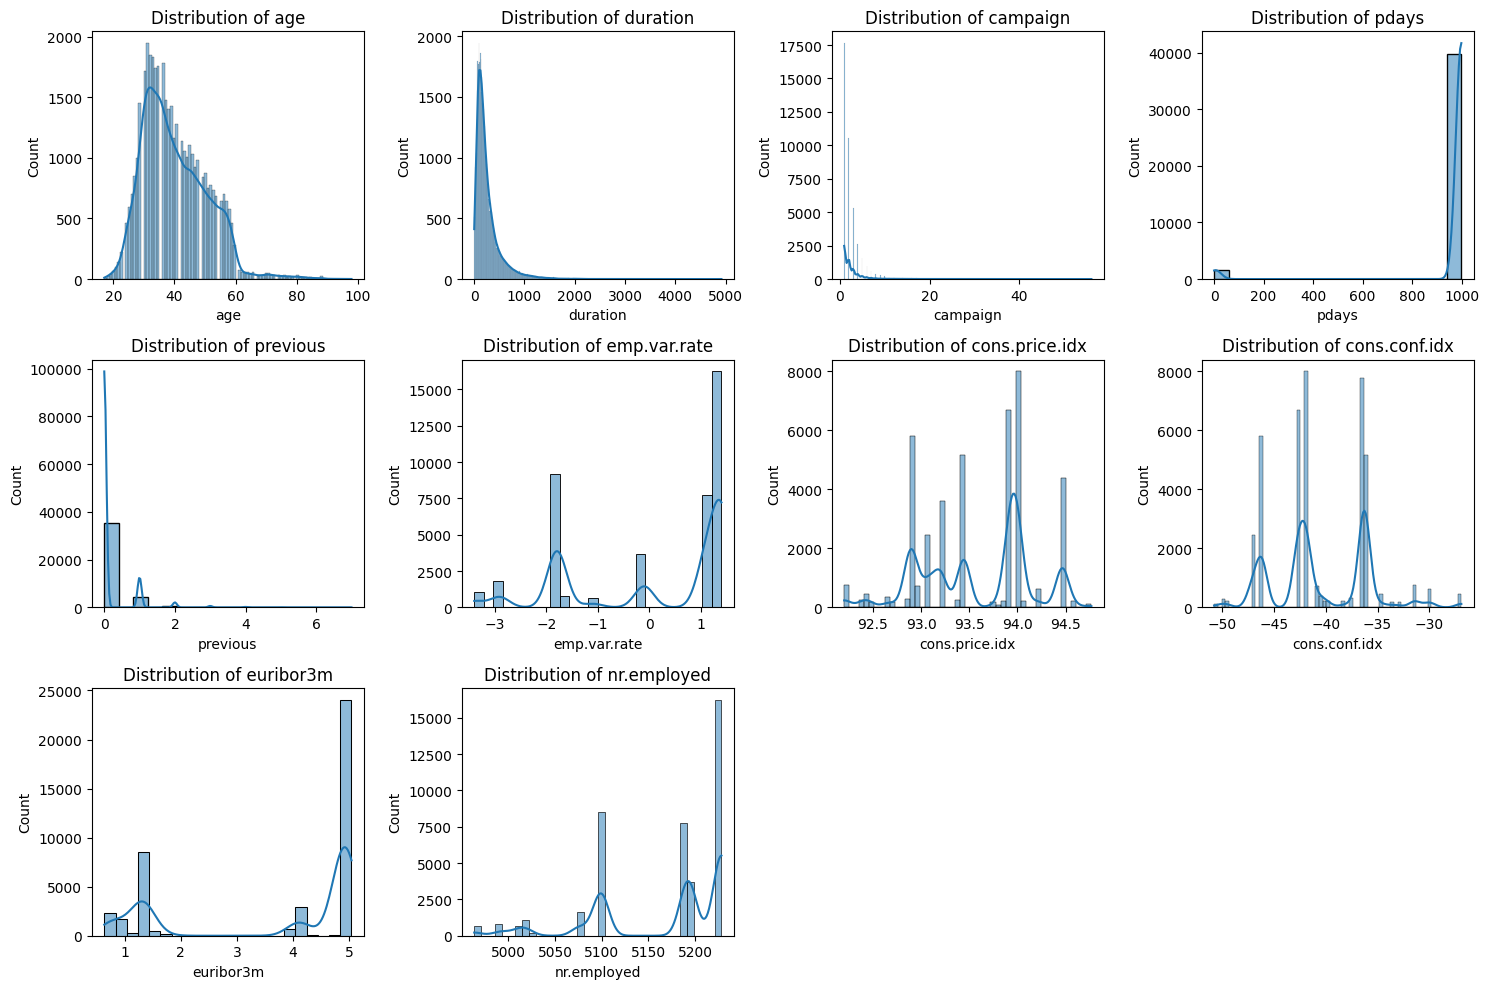

In [40]:
# Visualizing the distribution of numerical variables

plt.figure(figsize = (15, 10))
for i, feature in enumerate(number_df.columns):
    plt.subplot(3, 4, i+1)
    sns.histplot(data = df, x = feature, kde = True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

**Numerical Variables vs. Target Variable (y)**

Box plots help visualize the relationship between numerical features and the target variable, showing how different values of a numerical feature relate to whether the client subscribed to a term deposit.

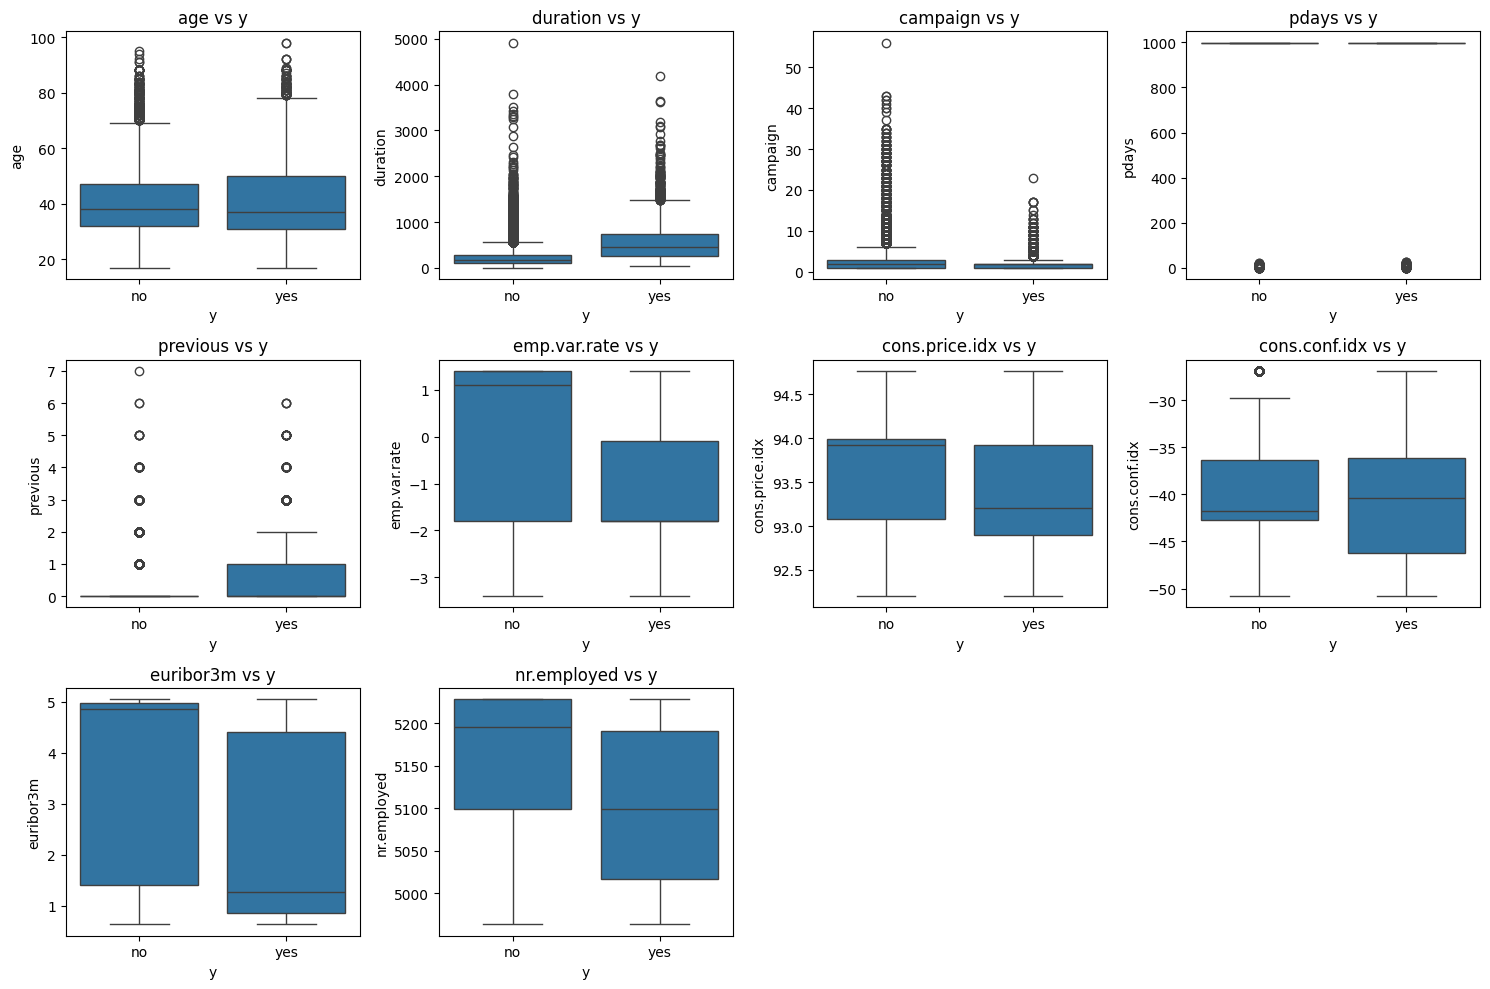

In [41]:
# Analyzing the relationship between numerical features and the target variable

plt.figure(figsize = (15, 10))
for i, feature in enumerate(number_df):
    plt.subplot(3, 4, i+1)
    sns.boxplot(data = df, x = 'y', y = feature)
    plt.title(f'{feature} vs y')
plt.tight_layout()
plt.show()

**Correlation Matrix for Numerical Variables**

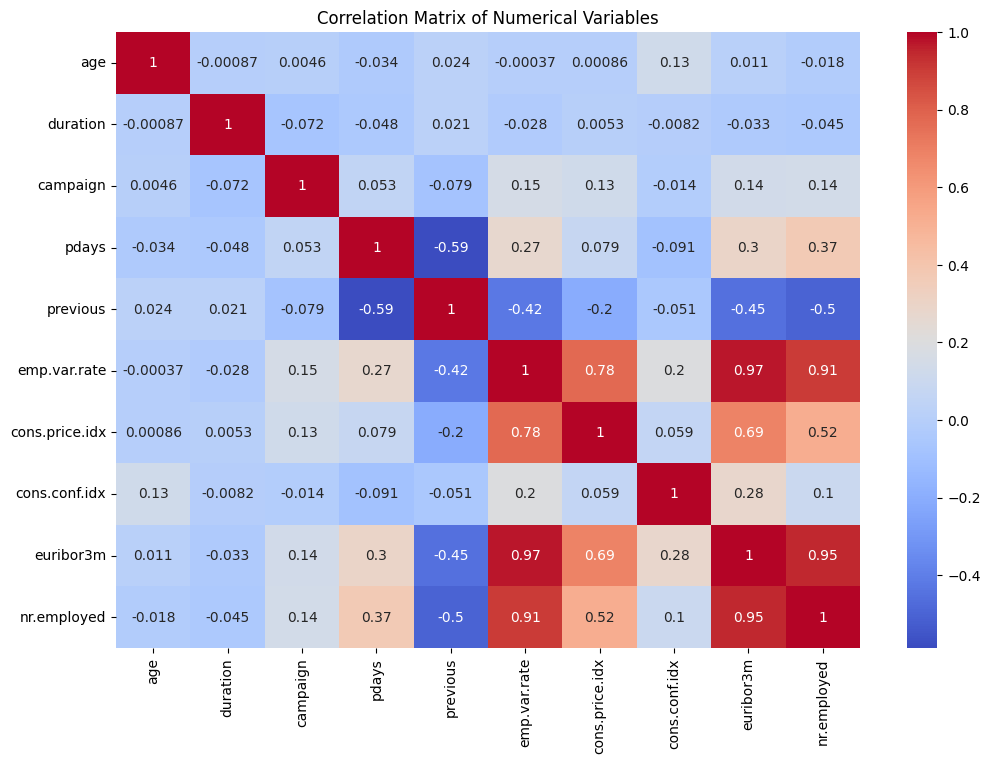

In [42]:
# Correlation matrix for numerical variables

plt.figure(figsize = (12, 8))
corr_matrix = number_df.corr()
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

The correlation matrix shows the relationships between the numerical features. Some features, such as emp.var.rate and euribor3m, have high correlations with each other, indicating potential multicollinearity.

## Initial Findings from the EDA

The dataset is highly imbalanced, with about 89% of clients not subscribing to the term deposit and only 11% subscribing.

### Categorical Variable Insights:
 - Job: Certain job categories, such as "blue-collar" and "services", have a higher proportion of clients who did not subscribe, while "management" roles are more likely to subscribe.
 - Education: Clients with higher education, especially those with a university degree, are more likely to subscribe.
 - Contact Method: Clients contacted via cellular communication show a higher success rate in subscribing.
 - Previous Campaign Outcome: Successful previous campaigns significantly increase the likelihood of current subscriptions.

### Numerical Variable Insights:
 - Duration: The length of the last contact is a strong indicator of whether a client will subscribe.
 - Previous Contacts: More previous contacts increase the probability of subscription.
 - Economic Indicators: Features like emp.var.rate, euribor3m, and nr.employed reflect the influence of economic conditions on client decisions.


### Hypothesis Formulation
 - Hypothesis 1: The longer the last contact with a client, the higher the probability that the client will subscribe to a term deposit.
 - Hypothesis 2: Clients with professional or managerial roles and higher education are more likely to subscribe.
 - Hypothesis 3: Clients with a successful experience in previous campaigns are more likely to subscribe again.
 - Hypothesis 4: Improvements in economic conditions (as indicated by features like emp.var.rate, euribor3m, and nr.employed) increase the likelihood of subscription.

# Proposed Machine Learning Methods for Binary Classification

The following machine learning methods are proposed for building binary classification models:

- **Logistic Regression:**
    - Advantages: Simple to implement, interpretable, and works well for linearly separable classes.
    - Disadvantages: May perform poorly with a large number of interdependent variables.

- **k-Nearest Neighbors (kNN):**
    - Advantages: Intuitive model, performs well with small datasets.
    - Disadvantages: Can be slow with large datasets and is sensitive to feature scaling.

- **Decision Tree:**
    - Advantages: Easy to interpret, can handle both numerical and categorical data without much preprocessing.
     - Disadvantages: Prone to overfitting if pruning is not applied.

- **Boosting Algorithms (e.g., XGBoost, LightGBM, CatBoost):**
    - Advantages: High performance, works well with large datasets, and can handle missing values.
    - Disadvantages: Hyperparameter tuning can be complex.

# Model Evaluation Metrics

For evaluating the quality of the classification models, the following metrics are recommended:

- **Accuracy:**
    - Advantages: Easy to understand.
    - Disadvantages: May not be appropriate for imbalanced datasets.

- **Precision and Recall:**
    - Advantages: Well-suited for evaluating imbalanced datasets.
    - Disadvantages: Precision may be low if the goal is to identify all positive cases (i.e., high recall).

- **F1-Score:**
    - Advantages: Balances precision and recall.
    - Disadvantages: Can be difficult to interpret if there is a large gap between precision and recall.

- **ROC AUC:**
    - Advantages: Suitable for evaluating models independently of thresholds.
    - Disadvantages: Can be challenging to interpret from a business perspective.

# Preprocessing Pipeline

Before building machine learning models, we need to preprocess our data. This includes:

1. Handling missing values.
2. Encoding categorical variables.
3. Scaling numerical variables.
4. Addressing Class Imbalance in the Dataset.

We will now define the preprocessing pipeline for both categorical and numerical features.

In [132]:
# Data Split for Training and Test
X = df.drop('y', axis = 1)
y = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

#Categorical and Numerical Features
categorical_features = X_train.select_dtypes(include = "object").columns.tolist()
numeric_features     = X_train.select_dtypes(include = "number").columns.tolist()

In [133]:
# Preprocessing pipeline for numerical variables
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical variables
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(drop = 'first'))
])

# Combining transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [134]:
# Creating pipelines for models
models = {
    'Logistic Regression': Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter = 1000))
    ]),
    'Decision Tree': ImbPipeline(steps = [
        ('preprocessor', preprocessor),
        ('smotetomek', SMOTETomek(random_state = 42)),
        ('classifier', DecisionTreeClassifier())
    ]),
    'k-Nearest Neighbors': ImbPipeline(steps = [
        ('preprocessor', preprocessor),
        ('smotetomek', SMOTETomek(random_state = 42)),
        ('classifier', KNeighborsClassifier())
    ]),
    'XGBoost': ImbPipeline(steps = [
        ('preprocessor', preprocessor),
        ('smotetomek', SMOTETomek(random_state = 42)),
        ('classifier', XGBClassifier(use_label_encoder = False, eval_metric = 'logloss'))
    ])
}

# Model Building and Evaluation

In this section, we will train several models and evaluate their performance:
1. Logistic Regression: A baseline model for binary classification.
2. Decision Tree: A more interpretable tree-based model.
3. k-Nearest Neighbors (kNN): A distance-based classifier.
4. XGBoost: A gradient-boosting model for better performance.

Each model will be evaluated on:
- Precision
- Recall
- F1-Score

In [ ]:
def plot_roc_all(models, X_val, y_val):
    """
    Plots the ROC curves for multiple models on the same graphic.

    Parameters:
        - models : A dictionary where keys are model names (str) and values are the corresponding trained model pipelines.
        - X_val : The validation input data used to compute predictions.
        - y_val : The true labels for the validation data.
    
    Returns:
        (None) Displays a plot of ROC curves for all provided models.
    """

    plt.figure(figsize = (8, 6))
    
    for model_name, model_pipeline in models.items():
        # Predict probabilities for the positive class
        y_val_pred = model_pipeline.predict_proba(X_val)[:, 1]

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_val, y_val_pred)
        auc = roc_auc_score(y_val, y_val_pred)

        # Plot ROC curve
        plt.plot(fpr, tpr, label = f"{model_name} AUC = {auc:.3f}")

    plt.title('ROC Curves for All Models')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")
    plt.grid()
    plt.show()

Training Logistic Regression...
Training Decision Tree...
Training k-Nearest Neighbors...
Training XGBoost...


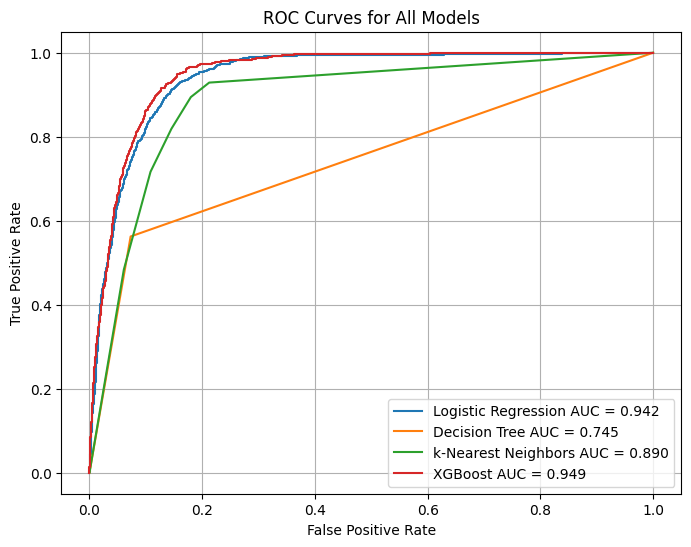

In [137]:
# Train and evaluate models
results = []

for model_name, model_pipeline in models.items():
    print(f"Training {model_name}...")

    # Fit model pipeline on the raw training data
    model_pipeline.fit(X_train, y_train)

    # Predict using the pipeline
    y_train_pred = model_pipeline.predict(X_train)
    y_test_pred  = model_pipeline.predict(X_test)

    # Generate classification reports
    train_report = classification_report(y_train, y_train_pred, output_dict = True)
    test_report   = classification_report(y_test, y_test_pred, output_dict = True)

    # Append results
    results.append({
        'model': model_name,
        'train_precision': train_report['weighted avg']['precision'],
        'train_recall': train_report['weighted avg']['recall'],
        'train_f1': train_report['weighted avg']['f1-score'],
        'test_precision': test_report['weighted avg']['precision'],
        'test_recall': test_report['weighted avg']['recall'],
        'test_f1': test_report['weighted avg']['f1-score']
    })

# Plot all ROC curves on one graphic
plot_roc_all(models, X_test, y_test)

In [138]:
# Displaying results as a table
results_df = pd.DataFrame(results)
display(results_df)

,model,train_precision,train_recall,train_f1,test_precision,test_recall,test_f1
0,Logistic Regression,0.90,0.91,0.90,0.91,0.92,0.91
1,Decision Tree,1.00,1.00,1.00,0.89,0.89,0.89
2,k-Nearest Neighbors,0.95,0.89,0.91,0.91,0.85,0.87
3,XGBoost,0.96,0.96,0.96,0.92,0.92,0.92


## Model Results Analysis

### Logistic Regression:
- **Train Precision, Recall, F1**: 0.90, 0.91, 0.90  
- **Test Precision, Recall, F1**: 0.91, 0.92, 0.91  

This model shows balanced results across the training and test sets, indicating good consistency without overfitting. It is a good choice for this task.

### Decision Tree:
- **Train Precision, Recall, F1**: 1.00, 1.00, 1.00  
- **Test Precision, Recall, F1**: 0.89, 0.89, 0.89  

This model is overfitted on the training data, as indicated by perfect metrics. However, its performance drops significantly on the test set. It may benefit from depth limitation or regularization techniques.

### k-Nearest Neighbors:
- **Train Precision, Recall, F1**: 0.95, 0.89, 0.91  
- **Test Precision, Recall, F1**: 0.91, 0.85, 0.87  

This model shows good results but slightly lower metrics on the test data compared to the training set, which could indicate slight overfitting. Tuning parameters like the number of neighbors (k) could improve it.

### XGBoost:
- **Train Precision, Recall, F1**: 0.96, 0.96, 0.96  
- **Test Precision, Recall, F1**: 0.92, 0.92, 0.92  

XGBoost performs exceptionally well on both training and test sets, indicating its ability to generalize well. This is one of the best-performing models for this task.

---

### Overall Conclusions:
- **Logistic Regression**: A good baseline model with balanced results, suitable for basic solutions.
- **Decision Tree**: Overfitted, requires regularization or pruning.
- **k-Nearest Neighbors**: Performs well but could benefit from parameter tuning.
- **XGBoost**: The best results across all models, recommended for production use.

# Randomized Search and Hyperopt Optimization with XGBoost

## Hyperparameter Tuning:

To improve model performance, we will apply hyperparameter tuning using two methods:

- **Randomized Search:** Fast, exploratory search over hyperparameter space.
- **Hyperopt:** Bayesian optimization to further refine the search.

### Randomized Search:
We will first use Randomized Search to identify promising hyperparameters for the XGBoost model.

### Hyperopt Search:
Once Randomized Search identifies a good range, we will use Hyperopt for a more focused optimization.


**Initial Parameters for XGBoost Model**

We start by defining initial parameters for the XGBoost model to serve as a baseline for tuning.

In [139]:
# Parameters used for the XGBoost model with initial values
initial_params = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'colsample_bytree': 0.8,
    'subsample': 0.8
}

# Creating the model with initial parameters
xgb_model = xgb.XGBClassifier(
    max_depth = initial_params['max_depth'],
    learning_rate = initial_params['learning_rate'],
    n_estimators = initial_params['n_estimators'],
    colsample_bytree = initial_params['colsample_bytree'],
    subsample = initial_params['subsample'],
    use_label_encoder = False,
    eval_metric = 'logloss'
)

**Randomized Search Parameter Distribution**

We define a range of values for each hyperparameter to search through during Randomized Search.

In [140]:
# Parameters for Randomized Search
param_dist = {
    'max_depth': range(3, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': range(50, 500, 50),
    'colsample_bytree': [0.3, 0.5, 0.7, 0.8, 0.9, 1.0],
    'subsample': [0.3, 0.5, 0.7, 0.8, 0.9, 1.0]
}

**Running Randomized Search**

Here, we use RandomizedSearchCV to randomly sample parameter combinations and evaluate the model based on the F1 score. We limit the number of iterations to 50 to balance performance and computational cost.

In [141]:
# Randomized Search
random_search = RandomizedSearchCV(
    estimator = xgb_model,
    param_distributions = param_dist,
    n_iter = 50,
    scoring = 'f1_weighted',
    cv = 3,
    verbose = 1,
    random_state = 42
)

# Fitting the model using Randomized Search
random_search.fit(preprocessor.fit_transform(X_train), y_train)
print("Best parameters found by Randomized Search:")
print(random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found by Randomized Search:
{'subsample': 0.7, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


**Model Evaluation Using Best Parameters from Randomized Search**

After finding the best parameters, we evaluate the performance of the tuned model on the test data and compute the F1 score.

In [142]:
best_random_search_model = random_search.best_estimator_
y_pred_random_search     = best_random_search_model.predict(preprocessor.transform(X_test))
f1_random_search         = f1_score(y_test, y_pred_random_search, average='weighted')
print(f"F1 Score for Randomized Search: {f1_random_search}")

F1 Score for Randomized Search: 0.9197790960278465


**Hyperopt Parameter Search Space**

We define the search space for Hyperopt, which will use the Tree-structured Parzen Estimator (TPE) algorithm to search for the best hyperparameters.

In [143]:
space = {
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', range(50, 500, 50)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'subsample': hp.uniform('subsample', 0.3, 1.0)
}

**Defining Objective Function for Hyperopt**

The objective function for Hyperopt minimizes the negative F1 score, as Hyperopt by default minimizes the given metric.

In [144]:
def objective(params):
    model = xgb.XGBClassifier(
        max_depth = params['max_depth'],
        learning_rate = params['learning_rate'],
        n_estimators = params['n_estimators'],
        colsample_bytree = params['colsample_bytree'],
        subsample = params['subsample'],
        use_label_encoder = False,
        eval_metric = 'logloss'
    )

    model.fit(preprocessor.transform(X_train), y_train)

    y_pred = model.predict(preprocessor.transform(X_test))
    f1     = f1_score(y_test, y_pred, average='weighted')
    
    return -f1  # Return negative F1 score for minimization

**Running Hyperopt**

Hyperopt will run for 50 evaluations, trying different parameter combinations to minimize the negative F1 score.

In [145]:
trials = Trials()

best_params_hyperopt = fmin(fn = objective, 
                            space = space, 
                            algo = tpe.suggest, 
                            max_evals = 50, 
                            trials = trials, 
                            rstate = np.random.default_rng(42))

print("Best parameters found by Hyperopt:")
print(best_params_hyperopt)

100%|██████████| 50/50 [00:35<00:00,  1.41trial/s, best loss: -0.9203474562026515]
Best parameters found by Hyperopt:
{'colsample_bytree': np.float64(0.7712773111917317), 'learning_rate': np.float64(0.0583899648411719), 'max_depth': np.int64(1), 'n_estimators': np.int64(7), 'subsample': np.float64(0.8961769347130212)}


**Model Evaluation Using Best Parameters from Hyperopt**

After Hyperopt finds the best parameters, we train a model with these parameters and compute its F1 score on the test data.

In [146]:
best_model_hyperopt = xgb.XGBClassifier(
    max_depth = best_params_hyperopt['max_depth'],
    learning_rate = best_params_hyperopt['learning_rate'],
    n_estimators = best_params_hyperopt['n_estimators'],
    colsample_bytree = best_params_hyperopt['colsample_bytree'],
    subsample = best_params_hyperopt['subsample'],
    use_label_encoder = False,
    eval_metric = 'logloss'
)

best_model_hyperopt.fit(preprocessor.transform(X_train), y_train)

y_pred_hyperopt = best_model_hyperopt.predict(preprocessor.transform(X_test))
f1_hyperopt     = f1_score(y_test, y_pred_hyperopt, average='weighted')

print(f"F1 Score for Hyperopt: {f1_hyperopt}")

F1 Score for Hyperopt: 0.8343887309826212


**Comparing Results**

Finally, we compare the F1 scores obtained through Randomized Search and Hyperopt to evaluate which method performed better.

In [147]:
print(f"F1 Score for Randomized Search: {f1_random_search}")
print(f"F1 Score for Hyperopt: {f1_hyperopt}")

F1 Score for Randomized Search: 0.9197790960278465
F1 Score for Hyperopt: 0.8343887309826212


**Best Model from Randomized Search and Feature Importance**

The best model, obtained through Randomized Search, is used to analyze the importance of each feature. This helps in understanding which features have the most influence on the model's predictions.

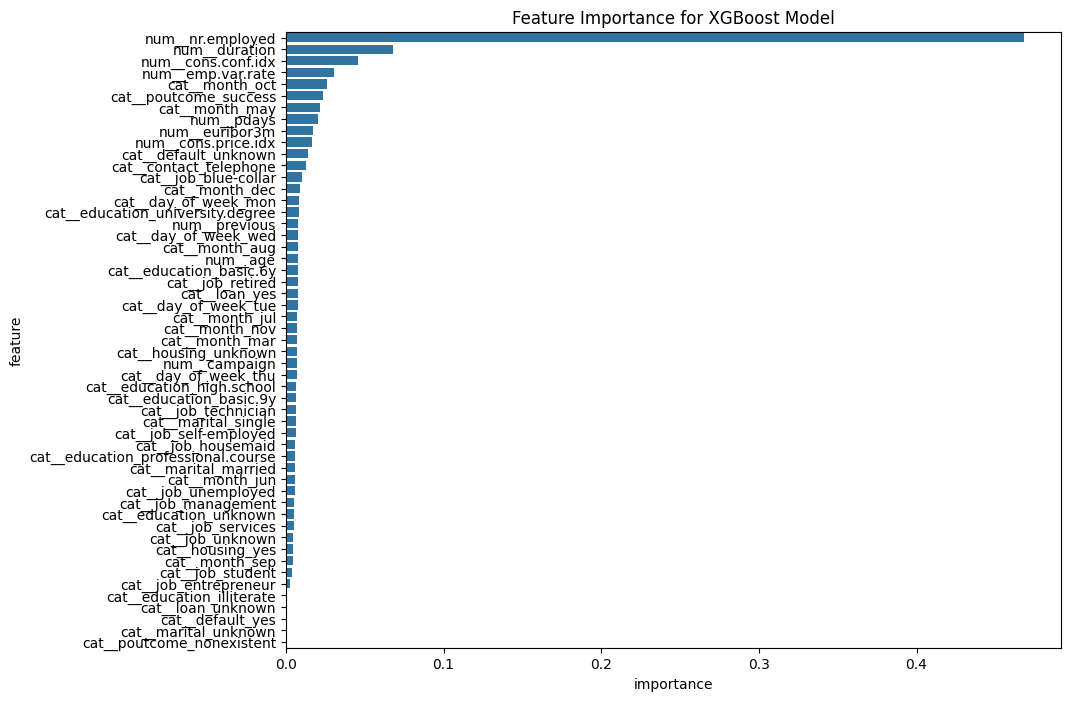

In [151]:
best_model = xgb.XGBClassifier(
    max_depth = 6,
    learning_rate = 0.05,
    n_estimators = 100,
    colsample_bytree = 1.0,
    subsample = 0.7,
    use_label_encoder = False,
    eval_metric = 'logloss'
)
best_model.fit(preprocessor.transform(X_train), y_train)

# Calculate feature importances
importance    = best_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by = 'importance', ascending = False)

# Visualizing feature importance
plt.figure(figsize = (10, 8))
sns.barplot(x = 'importance', y = 'feature', data = feature_importance_df)
plt.title('Feature Importance for XGBoost Model')
plt.show()

## Feature Importance Analysis

After analyzing the feature importance, we can conclude which features have the most impact on the model's results. Below are some of the most important features identified:

- **Number of employed (nr.employed):** This may reflect the overall economic climate, influencing clients' decisions.
- **Duration of the last contact (duration):** This makes sense as longer conversations may indicate greater client interest.
- **Change in employment rate (emp.var.rate):** Again, this is an indicator of the economic climate.

The most important features for the model included contact the number of employed individuals (nr.employed), duration (duration) and employment variation rate (emp.var.rate). These features significantly impact the final decision of whether the client will subscribe to the deposit.

# Error Analysis

To better understand the model's weaknesses, we will analyze the false positives and false negatives:

 - False Positives: Clients predicted to subscribe but did not.
 - False Negatives: Clients predicted not to subscribe but did.

## Confusion Matrix

We will first look at the confusion matrix to summarize the classification results.

In [153]:
# Predictions on the test set
y_pred = best_model.predict(preprocessor.transform(X_test))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Displaying the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[7084  226]
 [ 405  523]]


In [154]:
# Gathering the records where the model made mistakes
false_positives = X_test[(y_test == 0) & (y_pred == 1)]
false_negatives = X_test[(y_test == 1) & (y_pred == 0)]

# Analysis of the incorrect records
print("False Positives Analysis:")
print(false_positives.describe())

print("False Negatives Analysis:")
print(false_negatives.describe())

False Positives Analysis:
         age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed
count 226.00    226.00    226.00 226.00    226.00        226.00          226.00         226.00     226.00       226.00
mean   41.12    729.62      2.09 849.73      0.40         -1.31           93.29         -38.90       2.13      5096.04
std    14.42    476.28      1.54 355.52      0.71          1.70            0.69           5.97       1.77        88.35
min    18.00    103.00      1.00   1.00      0.00         -3.40           92.20         -50.80       0.64      4963.60
25%    31.00    340.50      1.00 999.00      0.00         -2.90           92.84         -42.70       0.81      5017.50
50%    37.00    640.00      2.00 999.00      0.00         -1.80           93.20         -40.30       1.26      5076.20
75%    49.00   1008.50      3.00 999.00      1.00         -0.10           93.92         -34.60       4.19      5195.80
max    92.00   3322.00

### Confusion Matrix Summary:

- **True Positives (TP):** 523  
- **True Negatives (TN):** 7084  
- **False Positives (FP):** 226  
- **False Negatives (FN):** 405  

### False Positives Analysis:
Age, duration of contact, number of previous contacts, and other features show significant variation. For example, the mean value for contact duration (duration) for false positives is 729.62 seconds, indicating longer conversations that still resulted in a failed outcome.

### False Negatives Analysis:
For false negatives, the average values differ slightly. For example, the mean value for contact duration (duration) for false negatives is 430.05 seconds, indicating slightly shorter conversations.

# Overall Conclusion

In this project, we analyzed a classification task to predict whether a client would subscribe to a term deposit. We explored the data, performed preprocessing, and created several machine learning models, including Logistic Regression, Decision Tree, k-Nearest Neighbors, and XGBoost.

## Key Results:

- **Logistic Regression**:
  - Strengths: Balanced between precision and recall.
  - Weaknesses: Slight underperformance in edge cases where decisions were less clear.
  - *Recommendation:* Suitable as a baseline model but could benefit from further feature engineering.

- **Decision Tree**:
  - Strengths: Provides easily interpretable results.
  - Weaknesses: Overfitting to the training data, leading to poor generalization on the test set.
  - *Recommendation:* Consider regularization or pruning techniques to improve generalization.

- **k-Nearest Neighbors (kNN)**:
  - Strengths: Competitive results in certain cases.
  - Weaknesses: Slightly reduced accuracy on the test set, with potential scalability issues.
  - *Recommendation:* Tuning hyperparameters and increasing the number of neighbors could improve performance.

- **XGBoost**:
  - Strengths: Demonstrated the highest accuracy and best-balanced performance across all metrics.
  - Weaknesses: Slight complexity in training and interpretation.
  - *Recommendation:* With hyperparameter tuning, this model is recommended for production use due to its robust performance.

We also performed hyperparameter tuning for the XGBoost model using Randomized Search and Hyperopt, which allowed us to find optimal parameters and improve the model's performance.

---

## Recommendations:

### 1. Model Optimization:
- Further tune hyperparameters for models like kNN and Decision Tree to minimize overfitting.
- Implement ensemble methods (e.g., stacking, boosting) to improve overall prediction accuracy.

### 2. Error Mitigation:
- Conduct deeper analysis on false positives and false negatives to identify patterns and address specific client segments.
- Explore additional features such as customer financial history or behavioral data to refine predictions.

---

# Conclusion:

In this project, the **XGBoost** model emerged as the top-performing classifier, providing balanced accuracy, precision, and recall. By focusing on key features such as `contact duration` and `employed individuals`, we identified critical drivers of client behavior.

## Key Takeaways:
1. **Best Model**: XGBoost with hyperparameter tuning via Randomized Search and Hyperopt.
2. **Important Features**: The most significant features were `duration`, `nr.employed`, and `emp.var.rate`.
3. **Error Insights**: False positives were associated with longer conversations, while false negatives often had shorter durations but still resulted in a subscription.

---

## Future Work:

Looking ahead, the following steps could further improve the model:

1. **Expand the dataset**: Introduce additional features like transactional data or past account activity.
2. **Deploy in production**: Implement real-time predictions using cloud-based infrastructure.
3. **Model Monitoring**: Regularly retrain the model to adapt to changing market conditions and customer behaviors.